## Summary

This notebook generates the freezeout graph, showing the density of WIMPs as function of time in the universe.
Read Dodelson! It is good!

## Imports

In [2]:
import scipy
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', size=22)
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rc('text', usetex=True)

## Functions

In [3]:
def neq(m, T):
    # Equilibrium number density in the universe
    # Equation 3.6 from Dodelson
    def E(p):
        return np.sqrt(m**2 + p**2)
    # Use approximations if applicable
    if m/T > 1e2:
        intresult = (m *T / (2 * np.pi))**(3/2) * np.exp(-m / T)
    if m/T < 1e-2:
        intresult = T**3 / (np.pi**2)
    else:
        intresult = scipy.integrate.quad(lambda p: 1/(2 * np.pi**2) * p**2 * np.exp(- E(p) / T), 0, np.inf)[0]
    return intresult

In [4]:
def yeq(x):
    # Equilibrium comoving density Y = n/T^3 as a function of x = m/T
    # All this is independent of m, so we set it to one!
    m = 1
    T = m / x
    n = neq(m, T)
    return n / T**3

In [5]:
# This is the differential equation 3.52 in Dodelson, giving Y as a function of time parameter.
# Why time parameter? Because the time of freezeout depends on the mass of the particle.
# We solve it numericaly because in general you have to
def model(y, x, labda):
    dydx = - labda / x**2 * (y**2 - yeq(x)**2)
    return dydx
# The initial density is equal to the equilibrium density
# 1e-3 is when there is still pretty nearly equilibrium
y0 = yeq(1e-3)

In [6]:
def get_omega(sigmav):
    # Get the freezeout density TODAY, when sigmav is entered in cm**2
    # Equation 3.60 Dodelson
    xf = 10
    gstar = 100
    h = 0.7
    return 0.3 * h**(-2) * (xf/10) * (gstar / 100)**(0.5) * 10**-39 / sigmav

def get_lambda(sigma, wimp_mass = 10):
    # Get the value of lambda for the differential equation 3.52
    # enter sigma in cm**2 and wimp mass in GeV
    sigmav = sigma * (50761)**2 # to get from cm**2 to eV-2
    m = wimp_mass * 1e9 #eV
    return m**3 * sigmav / H(m)

def H(T):
    '''
    The Hubble parameter as function of temperature, returned in units of 1/eV
    '''
    gstar = 100
    alphaG = 1.752e-45
    me = 511e3 #eV
    G = alphaG / (me**2) # 1/ev*2
    # G = 1 # https://en.wikipedia.org/wiki/Natural_units
    return T**2 * np.sqrt(8 * np.pi**3 * G * gstar / 45) # units 1/eV

## Plots

### The equilibrium density

The equilibrium number density will change with temperature. Here is how!

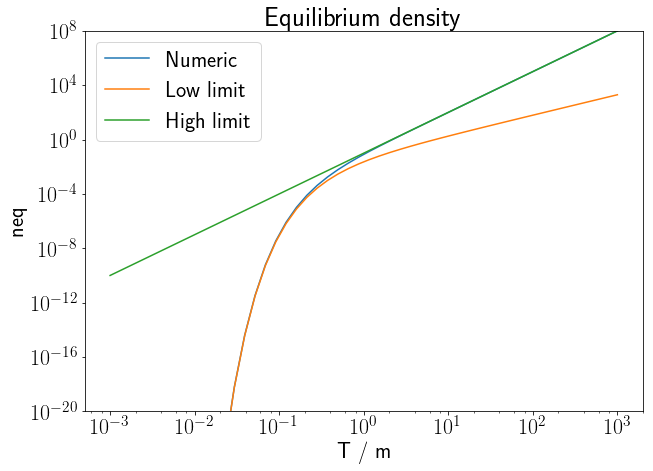

In [7]:
m = 1
T = np.logspace(-3, 3)
plt.plot(T, [neq(m, t) for t in T], label='Numeric')
plt.plot(T, [(m * t / (2 * np.pi))**(3/2) * np.exp(-m/t) for t in T], label='Low limit')
plt.plot(T, T**3/(np.pi**2), label='High limit')
plt.xlabel('T / m')
plt.ylabel('neq')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-20, 1e8)

plt.legend()
plt.title('Equilibrium density')

### Freezeout for one value of $\lambda$

Here is just one example of a freezeout graph. Don't worry, we are just building up to the final graph...

In [8]:
X = np.logspace(-3, 5, 200)

In [9]:
y1 = odeint(model, y0, X, args = (1e5,))

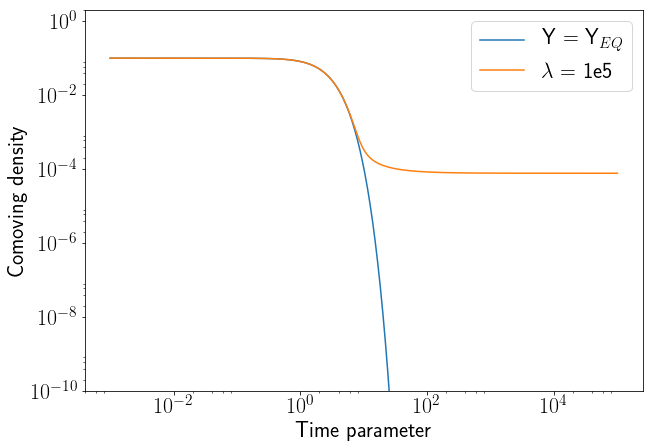

In [10]:
plt.plot(X, [yeq(x) for x in X], label='Y = Y$_{EQ}$')
plt.plot(X, y1, label='$\lambda$ = 1e5')


plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10, 2)
plt.legend()
plt.xlabel('Time parameter')
plt.ylabel('Comoving density')

### Freezeout for various cross sections

#### Auxilary functions

In [11]:
def labelplotter(X, Y, xloc, yshift, sigma, omega):
    # Plot Omega on top of the line at location xloc
    x = X[np.argmin(np.abs(X - xloc))]
    y = Y[np.argmin(np.abs(X - xloc))]
    y = y * yshift
    if omega < 0.1:
        plt.text(x, y, '$\Omega_{\chi} = $%.3f' % (omega))
    elif omega < 1:
        plt.text(x, y, '$\Omega_{\chi} = $%.2f' % (omega))
    else:
        plt.text(x, y, '$\Omega_{\chi} = $%.1f' % (omega))

In [12]:
def get_sigmalabel(sigma):
    # Nicely format the value of sigma into a cool label
    exponent = np.floor(np.log10(sigma))
    sigmalabel = r'$\sigma = $%.1f$\times$10$^{%d}$ cm$^{2}$' % (sigma / (10**(exponent)), exponent)
    return sigmalabel

In [13]:
import matplotlib as mpl
def draw_box(x, y, **kwargs):
    """Draw rectangle, given x-y boundary tuples"""
    # Arcane syntax of the week: matplotlib's Rectangle...
    plt.gca().add_patch(mpl.patches.Rectangle(
        (x[0], y[0]), x[1] - x[0], y[1] - y[0], **kwargs))

#### Generate data

The WIMP mass you set *will* alter the plot and the final value of Y, but *not* the freezeout value of Omega. This is because Y is a *number* density, so it gets multiplied by the mass. The higher the mass, the lower the number density!

Note that the bottom line in the plot will start to look ugly for masses greater than 40 GeV or so. It turns out that solving an integral differential equation on like 10 orders of magnitude is hard on good old scipy. Just keep it in bounds and say bye to your favourite WIMP mass...

Incidentally, the dependence on the freezout density on WIMP mass is weak, and, I believe, only there through the effective degrees of freedom. Basically, if the WIMP mass is high, the annihilation reactions are to more particles, as they are kinematically allowed to be produced.

In [14]:
wimp_mass = 10 # GeV

In [15]:
X = np.logspace(-3, 5, 200)
sigmas = [2e-40, 2e-39, 2e-38]
omegas = [get_omega(sigma) for sigma in sigmas]
lambdas = [get_lambda(sigma, wimp_mass) for sigma in sigmas]
ys = [odeint(model, y0, X, args = (labda,)) for labda in lambdas]
lws = [2.5, 4, 2.5]

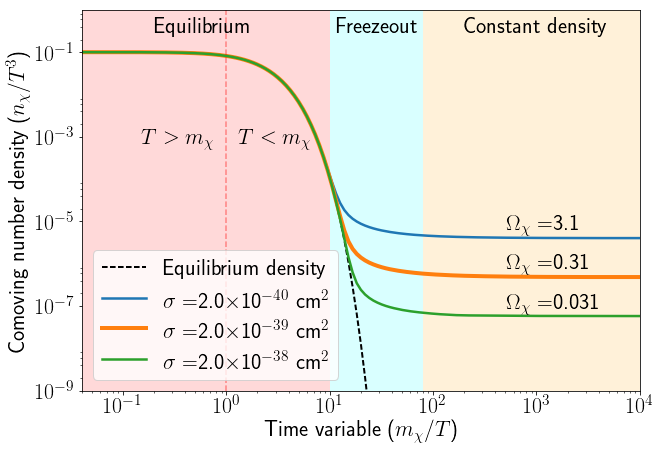

In [16]:
plt.plot(X, [yeq(x) for x in X], label='Equilibrium density', color='black', ls='--', lw=2)
for y, omega, sigma, lw in zip(ys, omegas,sigmas, lws):
    plt.plot(X, y, label = get_sigmalabel(sigma), lw = lw)
    labelplotter(X, y, 500, 1.3, sigma, omega)


plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-9, 1)
plt.xlim(4e-2, 1e4)
plt.xlim()
plt.xlabel('Time variable ($m_{\chi} / T$)')
plt.ylabel('Comoving number density ($n_{\chi} / T^3$)')
x0 = 10
x1 = 80
draw_box((1e-2, x0), (1e-11, 1), facecolor='red', alpha=0.15)
draw_box((x0, x1), (1e-11, 1), facecolor='cyan', alpha=0.15)
draw_box((x1, 1e5), (1e-11, 1), facecolor='orange', alpha=0.15)
plt.legend(loc='lower left')
yt = 0.3
plt.text(0.2, yt, 'Equilibrium')
plt.text(11.5, yt, 'Freezeout')#, rotation=-90)
plt.text(200, yt, 'Constant density')
plt.text(0.15, 0.0006, r'$T > m_{\chi}$')
plt.text(1.3, 0.0006, r'$T < m_{\chi}$')
plt.axvline(1, color='red', lw=2, ls='--', alpha=0.3)
plt.savefig('plots/freezeout.pdf', bbox_inches='tight')

In [17]:
# plt.plot(X, [yeq(x) for x in X], label='Equilibrium density', color='black', ls='--')
# for y, omega, sigma, lw in zip(ys, omegas,sigmas, lws):
#     plt.plot(X, y, label = get_sigmalabel(sigma), lw = lw)
#     labelplotter(X, y, 500, 1.3, sigma, omega)


# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-9, 1)
# plt.xlim(4e-2, 1e4)
# plt.xlim()
# plt.xlabel('Time variable ($m_{\chi} / T$)')
# plt.ylabel('Comoving number density ($n_{\chi} / T^3$)')
# # draw_box((1e-2, 5), (1e-11, 1), facecolor='red', alpha=0.1)
# # draw_box((5, 40), (1e-11, 1), facecolor='cyan', alpha=0.1)
# # draw_box((40, 1e5), (1e-11, 1), facecolor='orange', alpha=0.1)
# plt.legend(loc='lower left')
# yt = 0.3
# plt.text(0.2, yt, 'Equilibrium')
# plt.text(5.7, yt, 'Freezeout')
# plt.text(100, yt, 'Constant density')
# plt.savefig('plots/freezeout.pdf', bbox_inches='tight')